In [62]:
import pandas as pd
import numpy as np
import archiver_data_process as adp
import charge_plotter as cp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [63]:
# PARAMETERS TO SET WHEN GENERATING PLOTS
TOLERANCE = 0.2
MARGIN = 5
START = "2024/06/12 08:24:00"
END = "2024/06/12 08:34:00"
PV_CHARGE = "TORO:GUNB:360:CHRG"
PV_HOM = "SCOP:AMRF:RF01:AI_MEAS1"
PV_XCOR = "XCOR:GUNB:713:BACT"  
PV_BPMX = "BPMS:GUNB:925:X"  
PV_YCOR = "YCOR:GUNB:713:BACT" 
PV_BPMY = "BPMS:GUNB:925:Y" 
HOM_LABEL = "HOM C1"
XCOR_LABEL = "XCOR 04"
BPMX_LABEL = "BPMS 02 X"
YCOR_LABEL = "YCOR 04"
BPMY_LABEL = "BPMS 02 Y"

In [64]:
# create DataFrames for each PV
chrg_all = adp.pv(PV_CHARGE, START, END)
hom = adp.pv(PV_HOM, START, END)
xcor = adp.pv(PV_XCOR, START, END)
bpmx = adp.pv(PV_BPMX, START, END)
ycor = adp.pv(PV_YCOR, START, END)
bpmy = adp.pv(PV_BPMY, START, END)
df_chrg = adp.create_df(chrg_all)
df_chrg_50 = df_chrg[(df_chrg["TORO:GUNB:360:CHRG"] >= 50 - (50 * TOLERANCE)) & 
                     (df_chrg["TORO:GUNB:360:CHRG"] <= 50 + (50 * TOLERANCE))]
df_chrg_80 = df_chrg[(df_chrg["TORO:GUNB:360:CHRG"] >= 80 - (80 * TOLERANCE)) & 
                     (df_chrg["TORO:GUNB:360:CHRG"] <= 80 + (80 * TOLERANCE))]
df_hom = adp.create_df(hom)
df_hom = df_hom[(df_hom[PV_HOM] <= 0) & (df_hom[PV_HOM] >= -0.25)]
df_xcor = adp.create_df(xcor)
df_bpmx = adp.create_df(bpmx)
df_ycor = adp.create_df(ycor)
df_bpmy = adp.create_df(bpmy)

# create DataFrame with all PVs for a given charge
pv_list = [df_hom, df_xcor, df_bpmx, df_ycor, df_bpmy]
def create_correlation_df(df_chrg_val): 
    df_charge = pd.DataFrame()
    curr_df = df_chrg_val
    for df_pv in pv_list: 
        df_charge = adp.merge_dfs_with_margin_by_timestamp_column(curr_df, df_pv, MARGIN)
        curr_df = df_charge
    return df_charge
df_50 = create_correlation_df(df_chrg_50)
df_80 = create_correlation_df(df_chrg_80)

In [65]:
def plot_multi_correlation(df_charge_one, df_charge_two, pvx, pvy, xlabel, ylabel, xunits, yunits, one_charge_val, two_charge_val, multiply_factor=1):
    fig, ax = plt.subplots(figsize=(7, 7))
    def plot_points(df, pv_x, pv_y, x_label, y_label, x_units, y_units, point_color, line_color, label, factor=1): 
        x = df[pv_x]
        y = df[pv_y]
        ax.scatter(df[pv_x], df[pv_y])
        slope, intercept = np.polyfit(x, y, deg=1)
        ax.axline(xy1=(0, intercept), slope=slope, label=label, color=line_color)
        ax.scatter(x, y, color=point_color)
        # labels
        ax.set_title(f"{x_label} vs. {y_label}", fontsize=20)
        ax.set_xlabel(x_label + " " + x_units, fontsize=20)
        ax.set_ylabel(y_label + " " + y_units, fontsize=20)
        # ticks
        ax.set_xticks(np.linspace(min(x), max(x), 4))
        ax.set_yticks(np.linspace(min(y), max(y), 4))
        ax.set_xticklabels([f'{round(val * factor, 2):,}' for val in ax.get_xticks()])
        ax.set_yticklabels([f'{round(val, 2):,}' for val in ax.get_yticks()])
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.legend()
    plot_points(df_charge_one, pvx, pvy, xlabel, ylabel, xunits, yunits, "red", "red", one_charge_val, multiply_factor)
    plot_points(df_charge_two, pvx, pvy, xlabel, ylabel, xunits, yunits, "blue", "blue", two_charge_val, multiply_factor)
    plt.show()

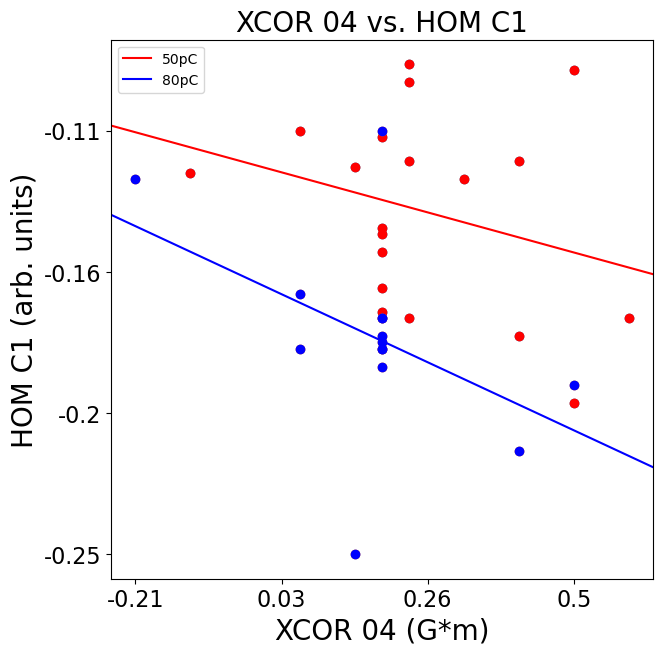

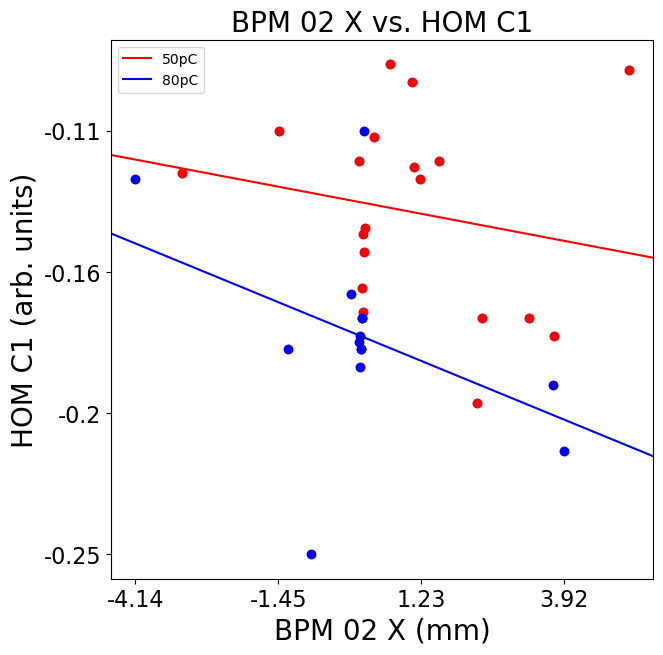

In [66]:
plot_multi_correlation(df_50, df_80, PV_XCOR, PV_HOM, "XCOR 04", "HOM C1", "(G*m)", "(arb. units)", "50pC", "80pC", 1000)
plot_multi_correlation(df_50, df_80, PV_BPMX, PV_HOM, "BPM 02 X", "HOM C1", "(mm)", "(arb. units)", "50pC", "80pC")